Housekeeping...

In [35]:
# Classic libraries
# from __future__ import division, print_function
import numpy as np
import sympy as sym
import pandas as pd
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sn # library for pretty plots. See https://stanford.edu/~mwaskom/software/seaborn/ 
sn.set_style('whitegrid')
cp = sn.xkcd_rgb["pinkish"]
cb = "#3498db"
cr = "#1fa774"
# Specialist functions
from scipy.optimize import minimize, root, fsolve
from scipy.optimize import leastsq, least_squares
from scipy.interpolate import interp1d
from scipy.special import erf
# Core functions - solve the problem and plot the results
import capital_new as capital
# Other extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading data from Adamopoulos and Restuccia (2014)

In [36]:
CalUS = np.loadtxt('model_data.csv', delimiter=',').T
CalP = np.loadtxt('model_data_p.csv', delimiter=',').T
y_grid, y_prob, farm_grid, k_grid, output_m = CalUS
y_grid_p, y_prob_p, farm_grid_p, k_grid_p, output_m_p = CalP

# Replicating Adamopoulos and Restuccia (2014) and some more using Eeckhout and Kircher (2016)
(or how heterogeneity in the quality of land cahnges the results or A&R)

## Index

1. [Introduction](#sec1)
2. [Calculating $k^*$](#sec2)
3. [Solving original model](#sec3)
4. [Uneven spread of $x$](#sec4)
  1. [Generating the distributions](#sec41)
  2. [Solving the model](#sec42)
  3. [Results](#sec43)
5. [The PAM condition](#sec5)



## 1. Introduction

The original A&R paper's production function is:

$$ p_aA\kappa(\eta(k)^{\rho} + (1 -\eta)(yl))^{\rho})^{\frac{\gamma}{\rho}} $$

Where:
- $y \to$ farmer skill
- $l \to$ farm size
- $k \to$ capital

The rest are parameters that are calibrated to match the farm size distribution of the US and the capital to land ratio.

E&K introduce two more variables:
- $x \to$ land quality
- $r \to$ farmer *supervising intentisty*, normalized to 1.

Adding heterogenity in land quality ($x$) to the A&R model requires a different solution method. 

The optimal choice of $k$ can be calculated as a function of the other variables so that the problem can be solved as an initial value problem (IVP) in the standard E&K way. That is, finding $k^*$ such that 
$$k^*(x,y,l,r) = \mathrm{argmax}_{k}F(x,y,l,r,k)-rRk$$

There is a number of ways of introducing these $x$ and $r$, of which 4 were considered. Below is the list of all tehm, with their accompaning first order condiction (FOC) for solving for $k^*(x,y,l,r)$.

| # | name | function | FOC    |
|---| ---- |:--------:|:--------:|
| 0 | $\color{red}{x}$ with $l/r$ | $ rp_aA\kappa(\eta(k)^{1/4} + (1 -\eta)(y(l/r)^{\color{red}{x}})^{1/4})^{2} - rRk$ | $ K^{3} + -\frac{Ap_a\kappa\eta^{2}}{2R} K + \frac{Ap_a\kappa\eta(1 -\eta)(y(\frac{l}{r})^{x})^{1/4}}{2R}   = 0$ |
| 1 | $\color{red}{x}$ with $A$ | $ rp_a\color{red}{x}A\kappa [\eta (k)^{1/4} + (1-\eta)(y(l/r))^{1/4} ]^2 - rRk $ | $K^3 - \frac{xAp_a\kappa\eta^2}{2R}K - \frac{xAp_a\kappa\eta(1-\eta)(y\frac{l}{r})^{1/4}}{2R}= 0 $ |
| 2 | $\color{red}{x}$ with $k$ | $ rp_aA\kappa [\eta (k\color{red}{x})^{1/4} + (1-\eta)(y(l/r))^{1/4} ]^2 - rRk $ | $K^3 - \frac{Ap_a\kappa\eta^2 x^{1/2}}{2R}K - \frac{Ap_a\kappa\eta(1-\eta)(xy\frac{l}{r})^{1/4}}{2R}= 0 $ |
| 3 | $\color{red}{x}$ with $k$ (out of the bracket) | $ rp_aA\kappa [\eta \color{red}{x} k^{1/4} + (1-\eta)(y(l/r))^{1/4} ]^2 - rRk $ | $K^3 - \frac{Ap_a\kappa\eta^2 x^2}{2R}K - \frac{Ap_a\kappa\eta(1-\eta)(y\frac{l}{r})^{1/4} x}{2R}= 0 $
| 4 | $k^{\color{red}{x}}$ | $ rp_aA\kappa(\eta(k)^{\color{red}{x}/4} + (1 -\eta)(y(l/r))^{1/4})^{2} - rRk$   | None |
*Note: $K = k^{1/4}$*

For the case of $k^{\color{red}{x}}$, there is no closed-form solution and $k^*$ has to be solved numerically. Solving the model with this especification renders the shooting solver I use unstable, therefore I do not use it. However, `capital.py` includes a function to carry this approximation out.

For the rest of the specifications, $k^*$ is found by solving a cubic root. This is done in section 2. `capital.py` approximates the solution with cubic or quadratic "tensor" polynomials - that is, polynomials with cross-products. This solves a multiple root problem and gives an easily differentiable expression (tht would make the solver work faster).

Once $k^*$ has been found, I proceed to solve for the baseline case where $x=1$ (section 3) and then increase the spread up to $x\in[0.75,1.25]$ (section 4). I use a shooting algorithm with logaritmic steps.

I chose to give $x$ a lognormal distribution (with mean 1) because is the one that makes the results move *closest* to the data - that is, small farms increasing size, but not much. I have left the code here to try other distributions and spreads. 

Finally, in section 5 I provide the symolic derivatives to the production function to show that with A&R parameters, PAM holds for any combination of $x,y,l,r$ and $k$.

<a id='sec2'></a>
## 2 Calculating $k^*$

In the past, I calculated the optimal choice of $k$ for different functional forms - that's why I creaded dictionaries with the keys being the different functional forms the production function could take. I have keep it that way to bear in mind that I chose function (2), but you can solve for $k$ for any of the four different production functions.

I also have different $k^*$ approximations depending on the maximum spread of $x$ (here [0.90,1.10] and [0.75,1.25]). Shorter spreads lead to more accurate results.

Rich country (US calibration):

In [37]:
pam_dic_R = {'A': 1.0, 'eta': 0.890204456766942, 'kappa': 0.3159, 'R':0.13099, 'rho': 0.25, 'gamma': 0.5}
pam_dic_P = {'A': 0.3987, 'eta': 0.890204456766942, 'kappa': 0.5209, 'R':0.3958, 'rho': 0.25, 'gamma': 0.5 }

k_star_R = capital.get_k(pam_dic_R, x_range=[0.9,1.1],print_residuals=True)
k_star_P = capital.get_k(pam_dic_P, x_range=[0.9,1.1],print_residuals=True)

0.0006049062442879255
0.00322205421125489


In [38]:
x, y, k = sym.var('x, y, k')
R, l, r, A, kappa, p_a, rho, gamma, eta = sym.var('R, l, r, A, kappa, p_a, rho, gamma, eta')

sym.init_printing()

F0 = r*A*kappa*(eta*k**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)
F1 = r*A*kappa*x*(eta*k**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F2 = r*A*kappa*(eta*(x*k)**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F3 = r*A*kappa*(x*eta*k**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F4 = r*A*kappa*(eta*k**(rho*x) + (1- eta)*((l/r)*y)**rho)**(gamma/rho)

lhs = F0.diff(x,y)*F0.diff(l,r)*F0.diff(k,k) - F0.diff(x,y)*F0.diff(l,k)*F0.diff(r,k) - F0.diff(x,k)*F0.diff(y,k)*F0.diff(l,r)
rhs = F0.diff(x,r)*F0.diff(y,l)*F0.diff(k,k) - F0.diff(x,r)*F0.diff(y,k)*F0.diff(l,k) - F0.diff(x,k)*F0.diff(y,l)*F0.diff(r,k)

PAM_R = sym.lambdify((x,y,l,r,k),sym.simplify(lhs-rhs).subs(pam_dic_R))
PAM_P = sym.lambdify((x,y,l,r,k),sym.simplify(lhs-rhs).subs(pam_dic_P))

<a id='sec3'></a>
## 3 Solving original model ($x=1$)

`capital.py` solves for no spread of $x$ first - the default values of the spread of $x$ being $(0.99999,1.00001)$.

In [46]:
sol_R1 = capital.solve("R", k_star_R, ftype=0,assort='positive',                       
                       verbose=False,guess_overide=0.8) #guess_overide=2000.0
# sol_P1 = capital.solve("P", k_starsP10[2], ftype=2,assort='positive',scaling_x=0.90607341901223637)scaling_x=0.90607341901223637,

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


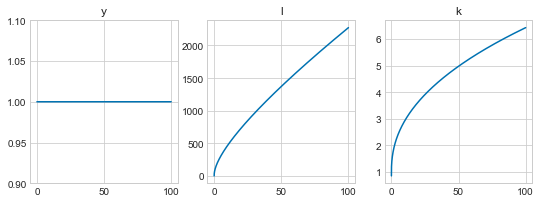

In [47]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.title('y')
plt.plot(sol_R1['xs'],sol_R1['ys'])
plt.ylim(0.9,1.1)
plt.subplot(132)
plt.title('l')
plt.plot(sol_R1['xs'],1/sol_R1['thetas'])
plt.subplot(133)
plt.title('k')
plt.plot(sol_R1['xs'],sol_R1['ks'])
plt.show()

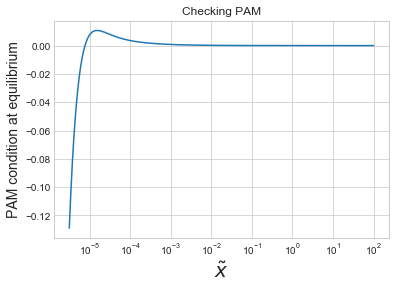

In [8]:
ders = capital.derivatives(sol_R1, "R")
capital.plot_PAM(ders, sol_R1['xs'])

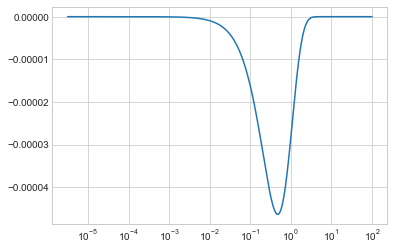

In [9]:
plt.plot(sol_R1['xs'],PAM_R(sol_R1['xs'],sol_R1['ys'],sol_R1['thetas'],1.0,sol_R1['ks']))
# plt.ylim(-0.01,0.01)
plt.xscale("log")
plt.show()

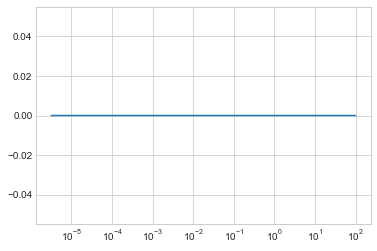

In [10]:
plt.plot(sol_R1['xs'],PAM_R(sol_R1['ys'],sol_R1['xs'],sol_R1['thetas'],1.0,sol_R1['ks'])>=0)
# plt.ylim(-0.01,0.01)
plt.xscale("log")
plt.show()

In [ ]:
sol_P1 = capital.solve("P", k_star_P, ftype=0,assort='positive',
                       verbose=False,guess_overide=2.0) #guess_overide=2000.0, scaling_x=0.90607341901223637,

Success! All workers and firms are matched


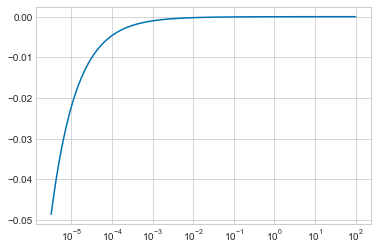

In [54]:
plt.plot(sol_P1['xs'],PAM_P(sol_P1['ys'],sol_P1['xs'],1/sol_P1['thetas'],1.0,sol_P1['ks']))
# plt.ylim(-0.2,0.2)
plt.xscale("log")
plt.show()

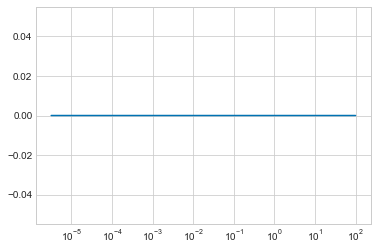

In [55]:
plt.plot(sol_P1['xs'],PAM_P(sol_P1['ys'],sol_P1['xs'],1/sol_P1['thetas'],1.0,sol_P1['ks'])>0)
plt.xscale("log")
plt.show()

Other functional forms

In [105]:
k_star_R2 = capital.get_k(pam_dic_R, ftype=1, x_range=[0.9,1.1])
sol_R2 = capital.solve("R", k_star_R2, ftype=1,assort='positive',
                       scaling_x=0.90607341901223637,
                       verbose=True,guess_overide=0.8) #guess_overide=2000.0
# sol_P1 = capital.solve("P", k_starsP10[2], ftype=2,assort='positive',scaling_x=0.90607341901223637)

Exhausted workers: initial guess of 0.4 for firm size is too high!
Exhausted workers: initial guess of 0.2 for firm size is too high!
Exhausted workers: initial guess of 0.1 for firm size is too high!
Exhausted workers: initial guess of 0.05 for firm size is too high!
Exhausted workers: initial guess of 0.025 for firm size is too high!
Exhausted workers: initial guess of 0.0125 for firm size is too high!
Exhausted workers: initial guess of 0.00625 for firm size is too high!
Exhausted workers: initial guess of 0.003125 for firm size is too high!
Exhausted workers: initial guess of 0.0015625 for firm size is too high!
Exhausted workers: initial guess of 0.00078125 for firm size is too high!
Exhausted firms: initial guess of 0.000390625 for firm size is too low.
Exhausted workers: initial guess of 0.0005859375000000001 for firm size is too high!
Exhausted firms: initial guess of 0.00048828125 for firm size is too low.
Exhausted workers: initial guess of 0.000537109375 for firm size is too

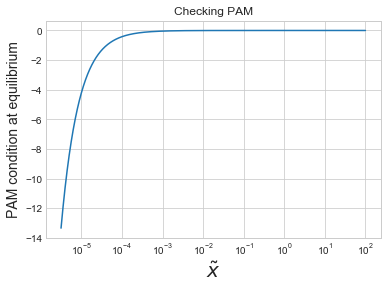

In [106]:
ders2 = capital.derivatives(sol_R2, "R")
capital.plot_PAM(ders2, sol_R2['xs'])

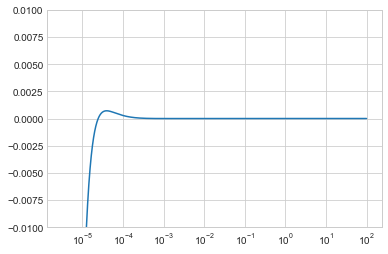

In [109]:
plt.plot(sol_R2['xs'],cond_exe(sol_R2['xs'],sol_R2['ys'],sol_R2['thetas'],1.0,sol_R2['ks']))
plt.ylim(-0.01,0.01)
plt.xscale("log")
plt.show()

In [98]:
k_star_R3 = capital.get_k(pam_dic_R, ftype=2, x_range=[0.9,1.1])
sol_R3 = capital.solve("R", k_star_R2, ftype=2,assort='positive',
                       scaling_x=0.90607341901223637,
                       verbose=True,guess_overide=0.0004886627197265625*2) #guess_overide=2000.0
# sol_P1 = capital.solve("P", k_starsP10[2], ftype=2,assort='positive',scaling_x=0.90607341901223637)

Exhausted firms: initial guess of 0.0004886627197265625 for firm size is too low.
Exhausted workers: initial guess of 0.0007329940795898437 for firm size is too high!
Exhausted workers: initial guess of 0.0006108283996582031 for firm size is too high!
Exhausted workers: initial guess of 0.0005497455596923829 for firm size is too high!
Exhausted workers: initial guess of 0.0005192041397094726 for firm size is too high!
Exhausted workers: initial guess of 0.0005039334297180175 for firm size is too high!
Exhausted workers: initial guess of 0.00049629807472229 for firm size is too high!
Exhausted workers: initial guess of 0.0004924803972244263 for firm size is too high!
Exhausted workers: initial guess of 0.0004905715584754943 for firm size is too high!
Exhausted workers: initial guess of 0.0004896171391010284 for firm size is too high!
Exhausted workers: initial guess of 0.0004891399294137955 for firm size is too high!
Exhausted workers: initial guess of 0.000488901324570179 for firm size

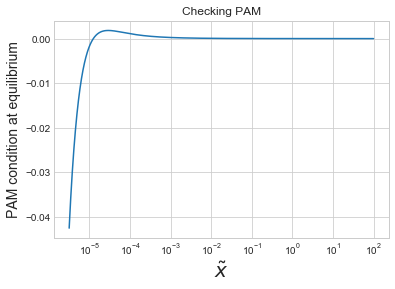

In [211]:
ders_p = capital.derivatives(sol_P1, "P")
capital.plot_PAM(ders_p, sol_P1['xs'])

**Note**: In order for the solver to match the lowest values of $y$ (0.000003) `capital.solve` uses an equivalent production function

$$lp_aA\kappa(\eta(yk)^{1/4} + (1 -\eta)(x(r/l))^{1/4})^{2} - lRk$$

This does not alter the results, but requires some care when dealing with the results: farm size ($\theta = \frac{l}{r}$) coming from the solver would be the inverse of model $\theta$, and in the code below you'll find `xs` refering to farmer skill ($y$ in the model).

Histogram comparing with the original paper (Figure 7 in the appendix):

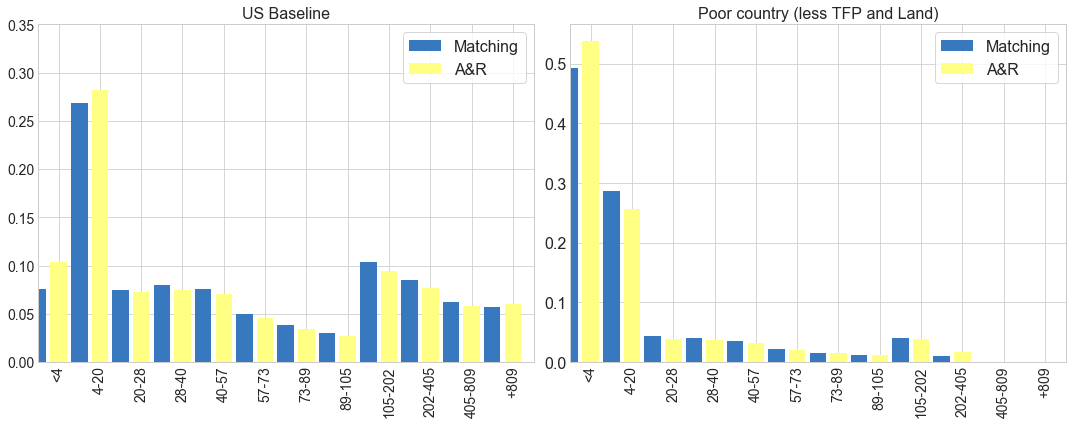

In [39]:
capital.plot_histogram(sol_R1,sol_P1,CalUS,CalP)

For comparison later on, I solve for increasing the spread evenly (uniform distribution) for different ranges of $x$:

**[put it on the server]**

In [12]:
sol_R10 = {}
sol_P10 = {}
# x_ranges = [(0.975,1.025),(0.95,1.05),(0.925,1.075),(0.9,1.1)]
x_ranges = [(0.95,1.05),(0.9,1.1)]

for i in range(len(x_ranges)):
    sol_R10[i] = capital.solve("R", k_star_R, ftype=0,assort='positive',x_range=x_ranges[i],scaling_x=0.90630885374008696)
    sol_P10[i] = capital.solve("P", k_star_P, ftype=0,assort='positive',x_range=x_ranges[i],scaling_x=0.90613690136320324)
    print("Done with range {}".format(x_ranges[i]))

KeyboardInterrupt: 

<a id='sec4'></a>
## 4. Uneven spread of x

Here I introduce different ways of spreading $x$. Although in the end only the lognormal is used, I've left the code written for other distributions as well to illustrate grphically how $x$ is unevenly changed.

<a id='sec41'></a>
### 4.1 Generating the distributions

Lognormal distribution:

In [8]:
_modules = [{'ImmutableMatrix': np.array, 'erf': erf, 'sqrt': np.sqrt}, 'numpy']

x, loc2, mu2, sigma2 = sym.var('x, loc2, mu2, sigma2')
productivity_cdf = (0.5 + 0.5 * sym.erf((sym.log(x - loc2) - mu2) / sym.sqrt(2 * sigma2**2)))

productivity_params_lognorm = {'loc2': 0.0, 'mu2': 0.00, 'sigma2': 0.20}

pdf_lognorm = productivity_cdf.diff(x).subs(productivity_params_lognorm)
pdf_exe_lognorm = sym.lambdify(x, pdf_lognorm, 'numpy')
cdf_exe_lognorm = sym.lambdify(x, productivity_cdf.subs(productivity_params_lognorm), _modules)

Bimodal

In [9]:
sig1, sig2, x, mu1, mu2= sym.var("sig1, sig2, x, mu1, mu2")
c1 = 0.5 * (1 + sym.erf((x-mu1)/ sym.sqrt(2 * sig1**2)))
c2 = 0.5 * (1 + sym.erf((x-mu2)/ sym.sqrt(2 * sig2**2)))
cdf = c1*0.5+c2*0.5

params_bimod = {'mu1': 0.93333, 'mu2': 1.06667, 'sig1': 0.033,'sig2': 0.033}

pdf_bimod = cdf.diff(x).subs(params_bimod)
cdf_bimod = cdf.subs(params_bimod)

pdf_exe_bimod = sym.lambdify(x, pdf_bimod,  _modules)
cdf_exe_bimod = sym.lambdify(x, cdf_bimod,  _modules)

Normal

In [10]:
params_norm = {'mu1': 1.0, 'sig1': 0.06666 }

pdf_norm = c1.diff(x).subs(params_norm)
cdf_norm = c1.subs(params_norm)

pdf_exe_norm = sym.lambdify(x, pdf_norm,  _modules)
cdf_exe_norm = sym.lambdify(x, cdf_norm,  _modules)

Normalising constants - so total ammount of land integrates to 1.

In [11]:
norm_bimod = 1/(cdf_exe_bimod(1.1)-cdf_exe_bimod(0.9))
norm_norm = 1/(cdf_exe_norm(1.1)-cdf_exe_norm(0.9))
norm_lognorm = 1/(cdf_exe_lognorm(1.1)-cdf_exe_lognorm(0.9))

c_bimod = cdf_exe_bimod(1.1)*norm_bimod-1
c_norm= cdf_exe_norm(1.1)*norm_norm-1
c_lognorm= cdf_exe_lognorm(1.1)*norm_lognorm-1

Normalising constants for different spreads, lognormal distribution

In [42]:
1/(cdf_exe_lognorm(0.999)-cdf_exe_lognorm(1.001))

In [12]:
norm_lognorm_05 = 1/(cdf_exe_lognorm(1.05)-cdf_exe_lognorm(0.95))
c_lognorm_05 = cdf_exe_lognorm(1.05)*norm_lognorm_05-1

norm_lognorm_10 = 1/(cdf_exe_lognorm(1.1)-cdf_exe_lognorm(0.9))
c_lognorm_10 = cdf_exe_lognorm(1.1)*norm_lognorm_10-1

norm_lognorm_15 = 1/(cdf_exe_lognorm(1.15)-cdf_exe_lognorm(0.85))
c_lognorm_15 = cdf_exe_lognorm(1.15)*norm_lognorm_15-1

norm_lognorm_20 = 1/(cdf_exe_lognorm(1.2)-cdf_exe_lognorm(0.8))
c_lognorm_20 = cdf_exe_lognorm(1.2)*norm_lognorm_20-1

norm_lognorm_25 = 1/(cdf_exe_lognorm(1.25)-cdf_exe_lognorm(0.75))
c_lognorm_25 = cdf_exe_lognorm(1.25)*norm_lognorm_25-1

norm_lognorm_30 = 1/(cdf_exe_lognorm(1.3)-cdf_exe_lognorm(0.7))
c_lognorm_30 = cdf_exe_lognorm(1.3)*norm_lognorm_30-1

Plots of the different distributions

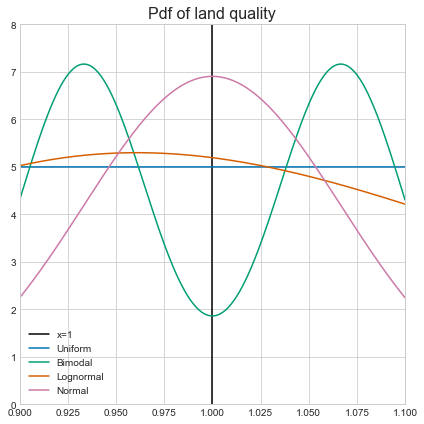

In [23]:
xss = np.linspace(0.9,1.1,6000)
plt.figure(figsize=(6,6))
sn.set_palette('colorblind', 5)
plt.axvline(1.0,label="x=1", c= 'black')
plt.plot(xss,5*np.ones(len(xss)), label="Uniform")
plt.plot(xss,pdf_exe_bimod(xss)*norm_bimod, label='Bimodal')
plt.plot(xss,pdf_exe_lognorm(xss)*norm_lognorm, label="Lognormal")
plt.xlim(0.9,1.1)
plt.ylim(0,8)
plt.title("Pdf of land quality", fontsize=16)
plt.plot(xss,pdf_exe_norm(xss)*norm_norm, label='Normal')


plt.tight_layout()
plt.legend(loc='best')
plt.show()

<a id='sec42'></a>
### 4.2 Solving the model

The distribution that used in the paper is the Lognormal (code 26xx). This distribution delivers the results closer to the data provided in Adamopoulos and Restuccia (2014).

In [24]:
# Execute this cell to store results
sol_log = {}
sol_logP = {}

Calculating $k^*(x,y,l,r)$ for different $x$ spreads:

In [26]:
k_star_R25 = capital.get_k(pam_dic_R, x_range=[0.75,1.25],print_residuals=True)
k_star_P25 = capital.get_k(pam_dic_P, x_range=[0.75,1.25],print_residuals=True)

k_star_R30 = capital.get_k(pam_dic_R, x_range=[0.7,1.3],print_residuals=True)
k_star_P30 = capital.get_k(pam_dic_P, x_range=[0.7,1.3],print_residuals=True)

0.0007566085962773021
0.004719416672145595
0.0008611003591574059
0.00560531009701687


Lognormal

In [27]:
sol_log[2605] = capital.solve("R", k_star_R, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.95,1.05],scaling_x=norm_lognorm_05, normconst=c_lognorm_05)
sol_logP[2605]= capital.solve("P", k_star_P, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.95,1.05],scaling_x=norm_lognorm_05, normconst=c_lognorm_05)

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [28]:
sol_log[2610] = capital.solve("R", k_star_R, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.9,1.1],scaling_x=norm_lognorm_10, normconst=c_lognorm_10)
sol_logP[2610]= capital.solve("P", k_star_P, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.9,1.1],scaling_x=norm_lognorm_10, normconst=c_lognorm_10)

Success! All workers and firms are matched
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [29]:
sol_log[2615] = capital.solve("R", k_star_R25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.85,1.15],scaling_x=norm_lognorm_15, normconst=c_lognorm_15,guess_overide=1/250)
sol_logP[2615]= capital.solve("P", k_star_P25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.85,1.15],scaling_x=norm_lognorm_15, normconst=c_lognorm_15,guess_overide=1/250)

Success! All workers and firms are matched
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [30]:
sol_log[2620] = capital.solve("R", k_star_R25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.8,1.20],scaling_x=norm_lognorm_20, normconst=c_lognorm_20,guess_overide=1/250)
sol_logP[2620]= capital.solve("P", k_star_P25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.8,1.20],scaling_x=norm_lognorm_20, normconst=c_lognorm_20,guess_overide=1/250)

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [31]:
sol_log[2625] = capital.solve("R", k_star_R25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.75,1.25],scaling_x=norm_lognorm_25, normconst=c_lognorm_25,guess_overide=1/250)
sol_logP[2625]= capital.solve("P", k_star_P25, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.75,1.25],scaling_x=norm_lognorm_25, normconst=c_lognorm_25,guess_overide=1/250)

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [32]:
sol_log[2630] = capital.solve("R", k_star_R30, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.7,1.3],scaling_x=norm_lognorm_30, normconst=c_lognorm_30,guess_overide=1/250)
sol_logP[2630]= capital.solve("P", k_star_P30, ftype=0,assort='positive',spread='lognorm',dispams=[0.00,0.2],
                             x_range=[0.7,1.3],scaling_x=norm_lognorm_30, normconst=c_lognorm_30,guess_overide=1/250)

Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.
Success! All workers and firms are matched
Approximated solution failed to satisfy required assortativity condition.


In [60]:
# solsR = (sol_R1,sol_log[2605],sol_log[2610],sol_log[2615],sol_log[2620],sol_log[2625],sol_log[2630])
# solsP = (sol_P1,sol_logP[2605],sol_logP[2610],sol_logP[2615],sol_logP[2620],sol_logP[2625],sol_logP[2630])
# labs = ('$x=0$','$x\in[0.95,1.05]$ ','$x\in[0.90,1.10]$','$x\in[0.85,1.15]$','$x\in[0.80,1.20]$','$x\in[0.75,1.25]$','$x\in[0.70,1.30]$')

solsR = (sol_R1,sol_log[2610],sol_log[2620],sol_log[2630])
solsP = (sol_P1,sol_logP[2610],sol_logP[2620],sol_logP[2630])
labs = ('$x=0$','$x\in[0.90,1.10]$','$x\in[0.80,1.20]$','$x\in[0.70,1.30]$')

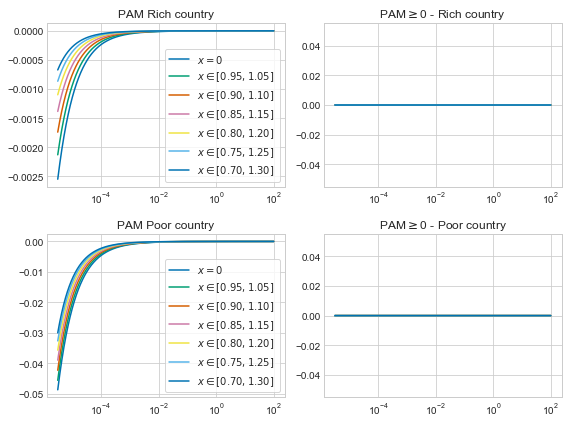

In [59]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.title('PAM Rich country')
for i,sol in enumerate(solsR):
    plt.plot(sol['xs'],PAM_R(sol['ys'],sol['xs'],1/sol['thetas'],1.0,sol['ks']), label=labs[i])
# plt.plot(sol_log[2625]['xs'],PAM_R(sol_log[2625]['ys'],sol_log[2625]['xs'],1/sol_log[2625]['thetas'],1.0,sol_log[2625]['ks']))
# plt.ylim(-0.2,0.2)
plt.legend(frameon=True)
plt.xscale("log")

plt.subplot(222)
plt.title('PAM$\geq$0 - Rich country')
for i,sol in enumerate(solsR):
    plt.plot(sol['xs'],PAM_R(sol['ys'],sol['xs'],1/sol['thetas'],1.0,sol['ks'])>=0, label=labs[i])
# plt.plot(sol_log[2625]['xs'],PAM_R(sol_log[2625]['ys'],sol_log[2625]['xs'],1/sol_log[2625]['thetas'],1.0,sol_log[2625]['ks'])>=0)
# plt.ylim(-0.2,0.2)
plt.xscale("log")

plt.subplot(223)
plt.title('PAM Poor country')
for i,sol in enumerate(solsP):
    plt.plot(sol['xs'],PAM_P(sol['ys'],sol['xs'],1/sol['thetas'],1.0,sol['ks']), label=labs[i])
# plt.ylim(-0.2,0.2)
plt.legend(frameon=True)
plt.xscale("log")

plt.subplot(224)
plt.title('PAM$\geq$0 - Poor country')
for i,sol in enumerate(solsP):
    plt.plot(sol['xs'],PAM_P(sol['ys'],sol['xs'],1/sol['thetas'],1.0,sol['ks'])>0, label=labs[i])

# plt.plot(sol_logP[2625]['xs'],PAM_P(sol_logP[2625]['ys'],sol_logP[2625]['xs'],1/sol_logP[2625]['thetas'],1.0,sol_logP[2625]['ks'])>=0)
# plt.ylim(-0.2,0.2)
plt.xscale("log")

plt.tight_layout()
plt.show()

<a id='sec43'></a>
### 4.3 Results

**Changes in farm size for widening spreads of $x$ **

In [50]:
# solsR = [sol_R1,] + list(sol_R10.values())
# solsP = [sol_P1] + list(sol_P10.values())
# labs = ('$x=1$','$x\in[0.975,1.025]$ ','$x\in[0.95,1.05]$ ','$x\in[0.925,1.075]$','$x\in[0.9,1.1]$')

In [36]:
for i,sol in enumerate(solsR):
    data = np.vstack((sol['xs'],sol['ys'],1/sol['thetas'],sol['ks'])).T
    np.savetxt('solR_'+labs[i]+'.csv', data, delimiter=',',header='xs, ys, ls, ks')
    
for i,sol in enumerate(solsP):
    data = np.vstack((sol['xs'],sol['ys'],1/sol['thetas'],sol['ks'])).T
    np.savetxt('solP_'+labs[i]+'.csv', data, delimiter=',',header='xs, ys, ls, ks')

In [33]:
labs = ('$x=0$','$x\in[0.90,1.10]$','$x\in[0.80,1.20]$','$x\in[0.70,1.30]$')
true_labs = ('$x=1$','$x\in[0.90,1.10]$','$x\in[0.80,1.20]$','$x\in[0.70,1.30]$')
solsP = []
for i,sol in enumerate(labs):
    buffsol = pd.read_csv('solP_'+labs[i]+'.csv', header=0,names=['xs', 'ys', 'thetas', 'ks'])
    buffsol['thetas'] = 1/buffsol['thetas']
    solsP.append(buffsol)
    

In logs:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


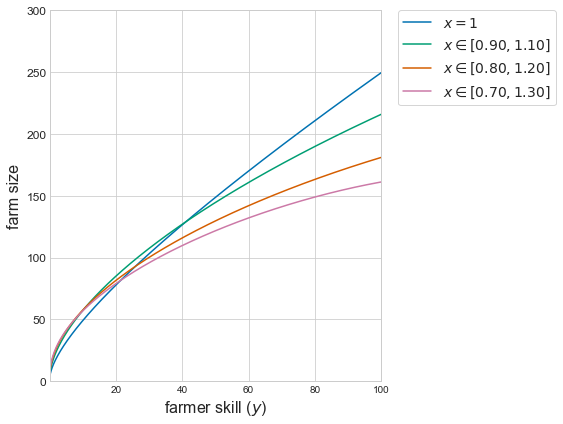

In [34]:
capital.plot_land_choice(solsP,true_labs, color=True, yscale=300,logs=False,save_in='land_choice_corrigendum_final.eps')

/Users/cristina/Documents/PJ/K/newK/capital_new.py:673: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
  


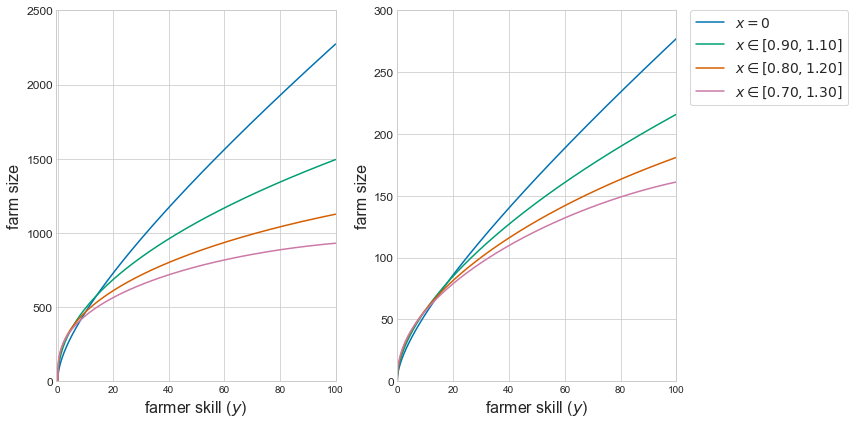

In [72]:
capital.plot_comparative_land_choice(solsR,labs,solsP,labs, color=True, logs=False)

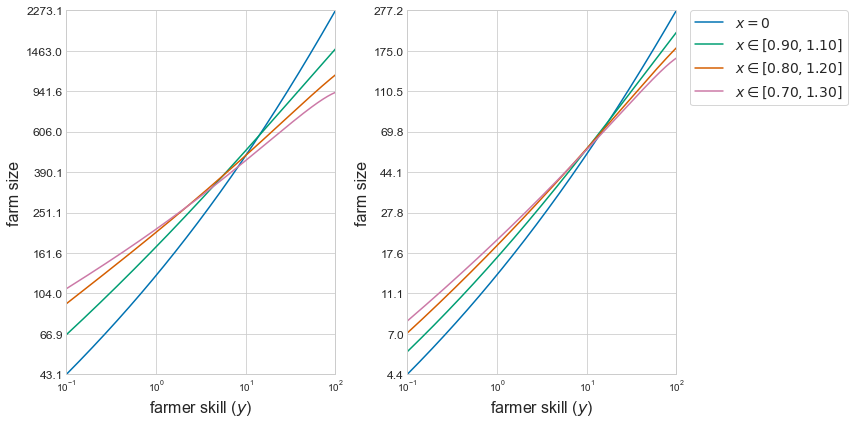

In [74]:
capital.plot_comparative_land_choice(solsR,labs,solsP,labs, color=True, logs=True)

In levels:

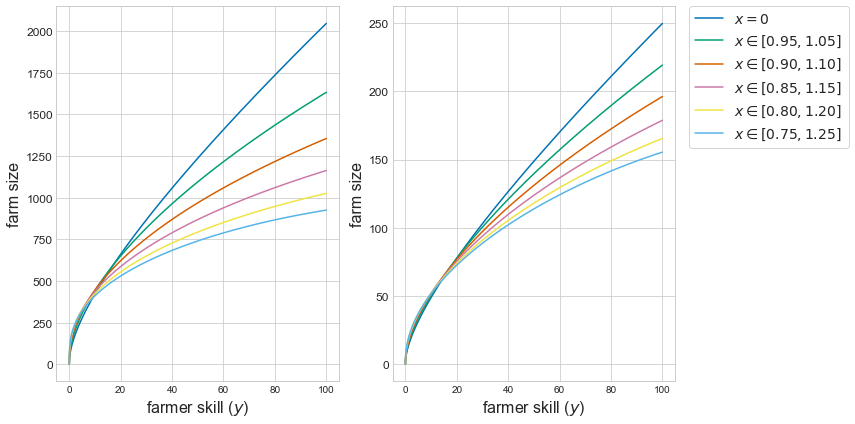

In [275]:
# New
capital.plot_land_choice(solsR,labs,solsP,labs, color=True, logs=False)

In [66]:
capital.plot_land_choice(solsR,labs,solsP,labs, color=True, logs=False)

TypeError: object of type 'NoneType' has no len()

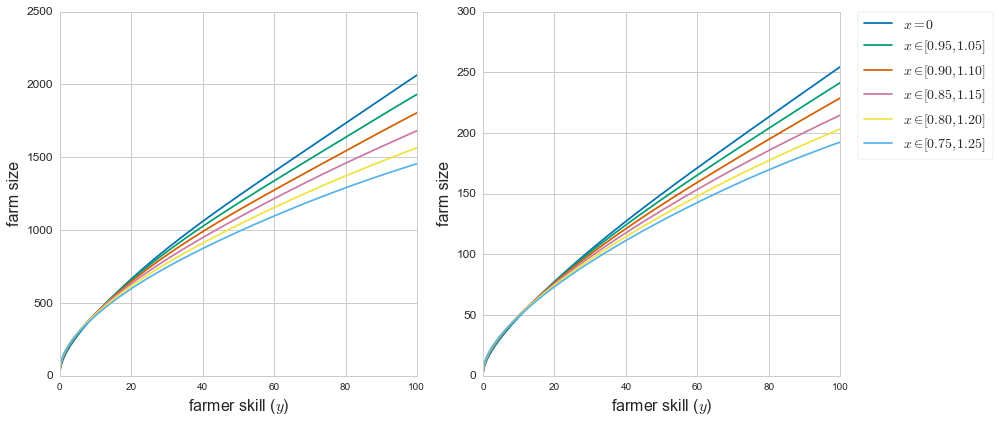

In [21]:
capital.plot_land_choice(solsR,labs,solsP,labs, color=True, logs=False)

Focusing on the poor country (Figure 1 in the paper):

ValueError: min() arg is an empty sequence

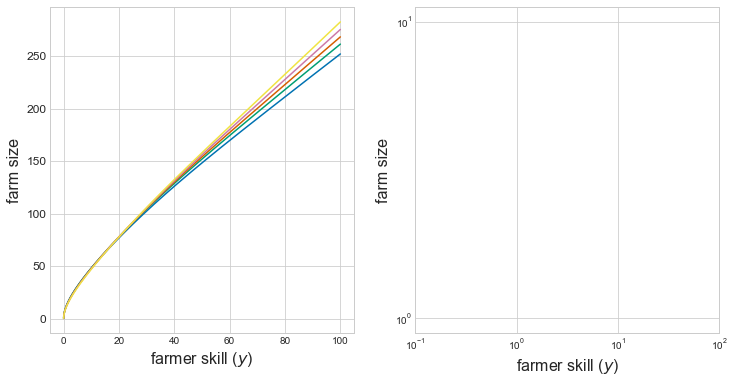

In [53]:
capital.plot_land_choice(solsP,labs,None,None, color=True, logs=False)#,save_in='Figure1.pdf'

** $k/l$ ratios **

These show the $k/l$ ratio normalized by the largest farm. That is, is $k/l=100$ for the largest farm, the $k/l$ ratio of the rest is divided by 100.

Rinch country on the left, poor country on the right.

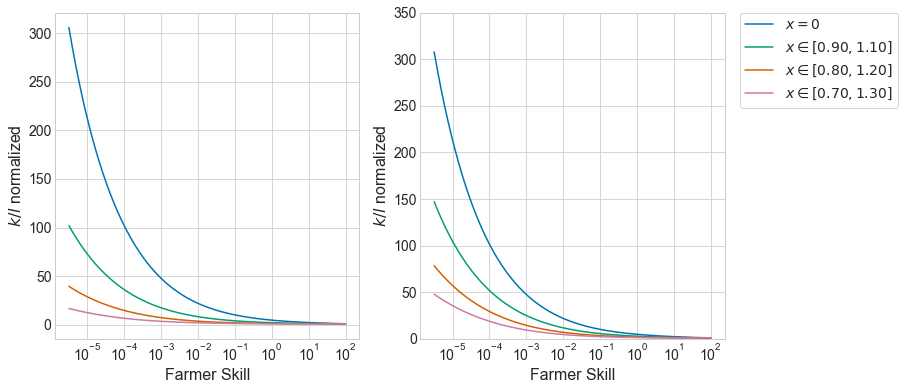

In [67]:
capital.plot_kl_ratio(solsR,labs,solsP,labs,save_in=None,color=True)

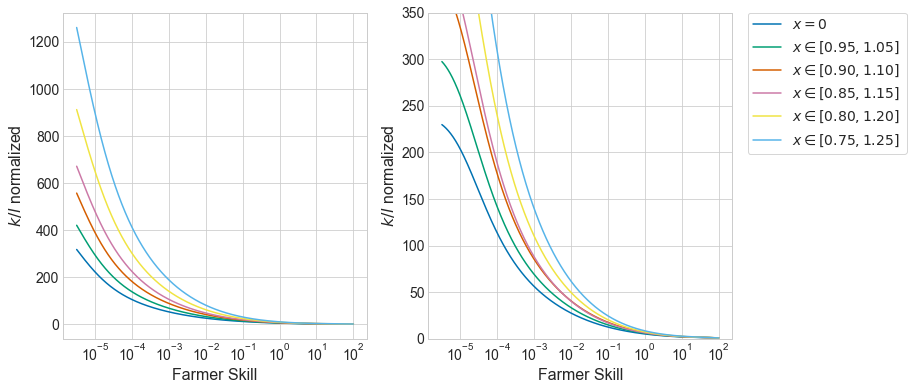

In [71]:
capital.plot_kl_ratio(solsR,labs,solsP,labs,save_in=None,color=True)

** Distribution plots **

Rich country:

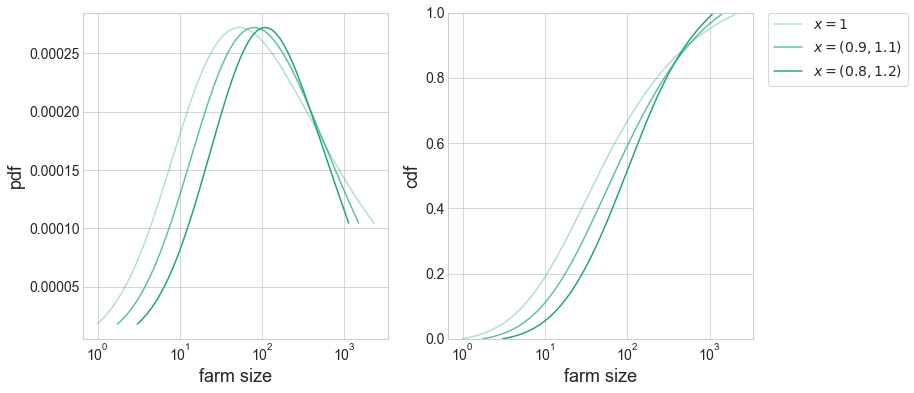

In [68]:
capital.plot_dischange(sol_R1,sol_log[2620],extras=[sol_log[2610],(0.9,1.1)],xrange=(0.8,1.2),
                            save_in=None,allplots=False,color=True, uc=cr)

Poor country:

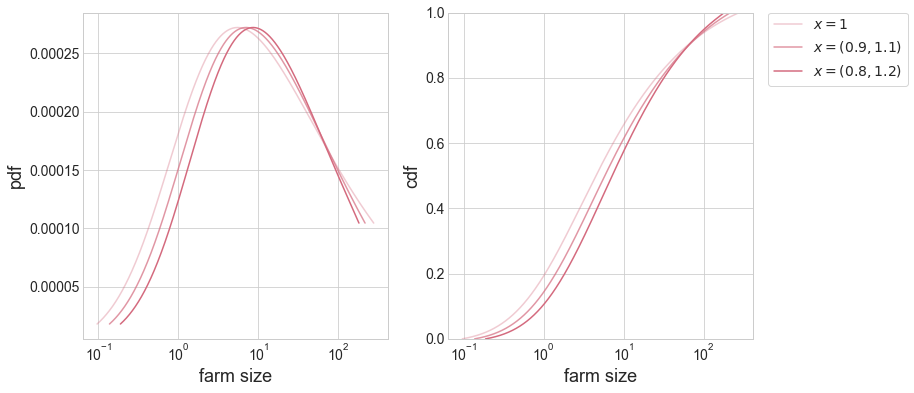

In [69]:
capital.plot_dischange(sol_P1,sol_logP[2620],extras=[sol_logP[2610],(0.9,1.1)],xrange=(0.8,1.2),
                            save_in=None, allplots=False,color=True,uc=cp)

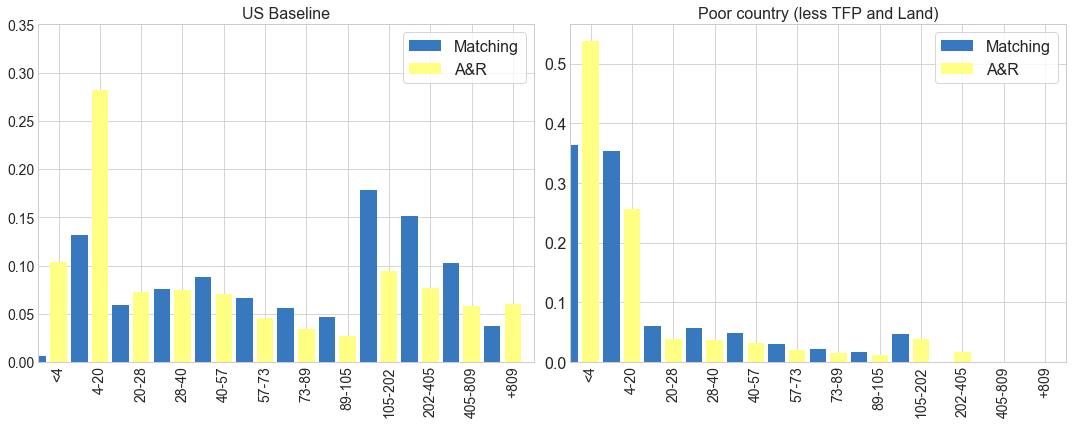

In [70]:
capital.plot_histogram(sol_log[2620],sol_logP[2620],CalUS,CalP,save_in=None)

In [82]:
#Loading data from model
xs1,thetas1, ks1, pdf_dis = sol_log[2620]['xs'],1/sol_log[2620]['thetas'],sol_log[2620]['ks'],sol_log[2620]['pdf_dis']
xs2,thetas2, ks2, pdf_dis_p = sol_logP[2620]['xs'],1/sol_logP[2620]['thetas'],sol_logP[2620]['ks'],sol_logP[2620]['pdf_dis']
y_grid, y_prob, farm_grid, k_grid, output_m = np.loadtxt('model_data.csv', delimiter=',').T
y_grid_p, y_prob_p, farm_grid_p, k_grid_p, output_m_p = np.loadtxt('model_data_p.csv', delimiter=',').T

In [83]:
#FARM Distribution of Farms by Quintile
#            #0-1	1-2     2--5	5-10	10-20	20-50	50-100	100-200	200-500	500+
farm_Q1 = np.array([0.549,0.171,0.216,0.047,0.015,0.002,0.000,0.000,0.000,0.000])

farm_Q5 = np.array([0.118,0.065,0.133,0.129,0.166,0.207,0.098,0.039,0.028,0.016])

#LAND Distribution of Farms by Quintile
#            #0-1	1-2     2--5	5-10	10-20	20-50	50-100	100-200	200-500	500+
land_Q1 = np.array([0.229,0.189,0.264,0.154,0.131,0.017,0.017,0.000,0.000,0.000])
land_Q5 = np.array([0.027,0.028,0.045,0.061,0.144,0.281,0.224,0.082,0.024,0.077])

fdp = [np.sum(farm_Q1[:3]),np.sum(farm_Q1[-5:])]
fdr = [np.sum(farm_Q5[:3]),np.sum(farm_Q5[-5:])]

In [84]:
h,b = np.histogram(thetas1, (0,5,20,4000), weights=pdf_dis)
h2,b2 = np.histogram(thetas2, (0,5,20,4000), weights=pdf_dis_p)
hm,bm = np.histogram(farm_grid, (0,5,20,4000), weights=y_prob)
hm2,bm2 = np.histogram(farm_grid_p, (0,5,20,4000), weights=y_prob_p)

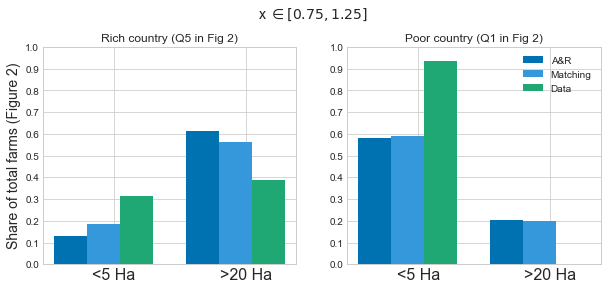

In [97]:
plt.figure(figsize=(10,4))
plt.suptitle(r"x $\in [0.75,1.25]$".format(i),y=1.02,fontsize=14)
plt.subplot(1,2,1)
plt.bar(np.arange(len(h)-1),[hm[0],hm[2]],width=0.25, label='A&R')
plt.bar(np.arange(len(h)-1)+0.25,[h[0],h[2]],width=0.25, color=cb,label='Matching')
plt.bar(np.arange(len(h)-1)+0.5,fdr,width=0.25, color=cr, label='Data')
plt.xticks((0.33,1.33), ('<5 Ha','>20 Ha'), fontsize=16)
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
plt.ylabel("Share of total farms (Figure 2)", fontsize=14)
plt.title("Rich country (Q5 in Fig 2)")
plt.subplot(1,2,2)
plt.bar(np.arange(len(h2)-1),[hm2[0],hm2[2]],width=0.25, label='A&R')
plt.bar(np.arange(len(h2)-1)+0.25,[h2[0],h2[2]],width=0.25,color=cb, label='Matching')
plt.bar(np.arange(len(h)-1)+0.5,fdp,width=0.25, color=cr, label='Data')
plt.xticks((0.33,1.33), ('<5 Ha','>20 Ha'), fontsize=16)
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,0.1))
plt.legend()
plt.title("Poor country (Q1 in Fig 2)")
plt.show()

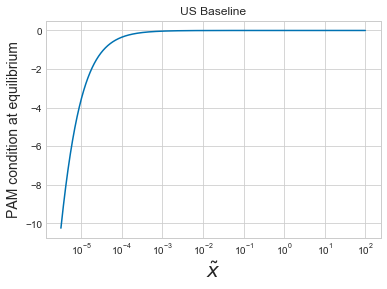

In [88]:
ders = capital.derivatives(sol_log[2620], "R")
capital.plot_PAM(ders, sol_log[2620]['xs'])

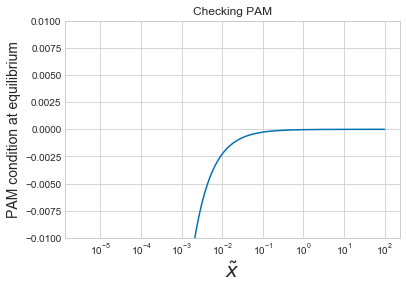

In [96]:
ders = capital.derivatives(sol_R1, "R")
capital.plot_PAM(ders, sol_R1['xs'],zoom=(-0.01,0.01))

<a id='sec5'></a>
## 5. PAM condition

Does the PAM condition hold? Here I check for the PAM condition, so if lhs-rhs > 0, then PAM holds.

First without substituiting parameters:

In [91]:
x, y, k = sym.var('x, y, k')
R, l, r, A, kappa, p_a, rho, gamma, eta = sym.var('R, l, r, A, kappa, p_a, rho, gamma, eta')
pam_dic_P['rho']=0.25
pam_dic_P['gamma']=0.5

pam_dic_R['rho']=0.25
pam_dic_R['gamma']=0.5

sym.init_printing()

F0 = r*A*kappa*(eta*k**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)
F1 = r*A*kappa*x*(eta*k**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F2 = r*A*kappa*(eta*(x*k)**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F3 = r*A*kappa*(x*eta*k**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
F4 = r*A*kappa*(eta*k**(rho*x) + (1- eta)*((l/r)*y)**rho)**(gamma/rho)

In [96]:
lhs = F0.diff(x,y)*F0.diff(l,r)*F0.diff(k,k) - F0.diff(x,y)*F0.diff(l,k)*F0.diff(r,k) - F0.diff(x,k)*F0.diff(y,k)*F0.diff(l,r)
rhs = F0.diff(x,r)*F0.diff(y,l)*F0.diff(k,k) - F0.diff(x,r)*F0.diff(y,k)*F0.diff(l,k) - F0.diff(x,k)*F0.diff(y,l)*F0.diff(r,k)
print(sym.latex(sym.simplify(lhs-rhs).subs(pam_dic_R)))

\frac{0.00350791171645153 r^{2} x \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.5} \left(- 0.00134143366352266 k^{0.25} - 0.000496347002123088 \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.25}\right) \left(0.890204456766942 k^{0.25} + 0.109795543233058 \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.25}\right)^{6.0}}{k^{1.75} l y \left(0.00471307000952237 k^{0.25} \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.75} + 0.0573192108348017 k^{0.5} \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.5} + 0.309823243220936 k^{0.75} \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.25} + 0.627999151431458 k^{1.0} + 0.000145324503280975 \left(y \left(\frac{l}{r}\right)^{x}\right)^{1.0}\right)}


In [97]:
print(sym.latex(sym.simplify(lhs-rhs).subs(pam_dic_P)))

\frac{0.000996785143643158 r^{2} x \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.5} \left(- 0.00134143366352266 k^{0.25} - 0.000496347002123088 \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.25}\right) \left(0.890204456766942 k^{0.25} + 0.109795543233058 \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.25}\right)^{6.0}}{k^{1.75} l y \left(0.00471307000952237 k^{0.25} \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.75} + 0.0573192108348017 k^{0.5} \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.5} + 0.309823243220936 k^{0.75} \left(y \left(\frac{l}{r}\right)^{x}\right)^{0.25} + 0.627999151431458 k^{1.0} + 0.000145324503280975 \left(y \left(\frac{l}{r}\right)^{x}\right)^{1.0}\right)}


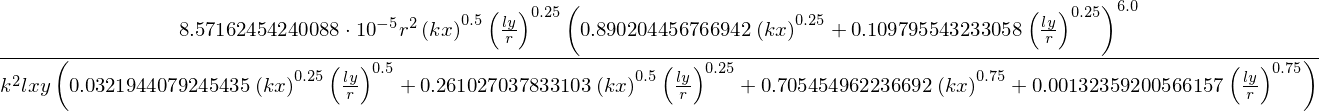

In [85]:
lhs = F2.diff(x,y)*F2.diff(l,r)*F2.diff(k,k) - F2.diff(x,y)*F2.diff(l,k)*F2.diff(r,k) - F2.diff(x,k)*F2.diff(y,k)*F2.diff(l,r)
rhs = F2.diff(x,r)*F2.diff(y,l)*F2.diff(k,k) - F2.diff(x,r)*F2.diff(y,k)*F2.diff(l,k) - F2.diff(x,k)*F2.diff(y,l)*F2.diff(r,k)
sym.simplify(lhs-rhs).subs(pam_dic_R)

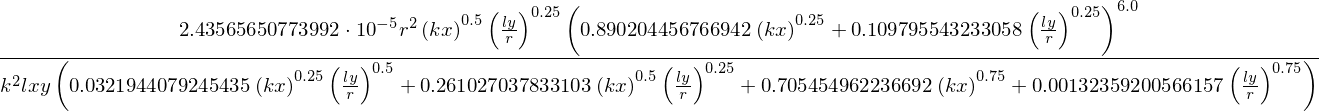

In [86]:
sym.simplify(lhs-rhs).subs(pam_dic_P)

Then substituiting all the parameters fixed across countries:

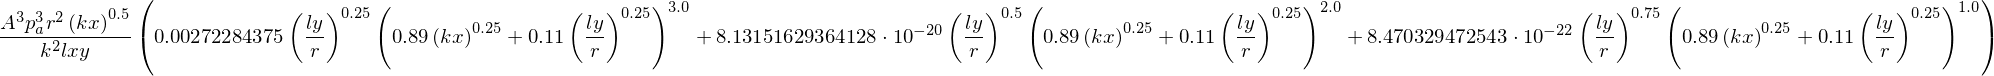

In [8]:
eta = 0.89
rho = 0.25
gamma = 0.5
kappa = 1

F = r*p_a*A*kappa*(eta*(x*k)**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
lhs = F.diff(x,y)*F.diff(l,r)*F.diff(k,k) - F.diff(x,y)*F.diff(l,k)*F.diff(r,k) - F.diff(x,k)*F.diff(y,k)*F.diff(l,r)
rhs = F.diff(x,r)*F.diff(y,l)*F.diff(k,k) - F.diff(x,r)*F.diff(y,k)*F.diff(l,k) - F.diff(x,k)*F.diff(y,l)*F.diff(r,k)
sym.simplify(lhs-rhs)

In [ ]:
eta = 0.89
rho = 0.25
gamma = 0.5
kappa = 1

F = r*p_a*A*kappa*(eta*(x*k)**rho + (1- eta)*((l/r)*y)**rho)**(gamma/rho)
lhs = F.diff(x,y)*F.diff(l,r)*F.diff(k,k) - F.diff(x,y)*F.diff(l,k)*F.diff(r,k) - F.diff(x,k)*F.diff(y,k)*F.diff(l,r)
rhs = F.diff(x,r)*F.diff(y,l)*F.diff(k,k) - F.diff(x,r)*F.diff(y,k)*F.diff(l,k) - F.diff(x,k)*F.diff(y,l)*F.diff(r,k)
sym.simplify(lhs-rhs)